# Kanapy
## Analysis of EBSD maps and generation of voxelated RVE

Author: Alexander Hartmaier<br>ICAMS, Ruhr University Bochum, Germany<br>
November 2023

### 1. Prepare system settings

In [1]:
import kanapy as knpy
import numpy as np


### 2. Analyse EBSD map with MTEX module and obtain statistical information

<img alt="EBSD map 316L" src="./ebsd_316L_experiment.png">
<img src="./IPFkey.png" alt="IPF key" style="width:200px">


I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  .... done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 
  I'm going to colorize the orientation data with the 
  standard MTEX ipf colorkey. To view the colorkey do:
 
  ipfKey = ipfColorKey(ori_variable_name)
  plot(ipfKey)


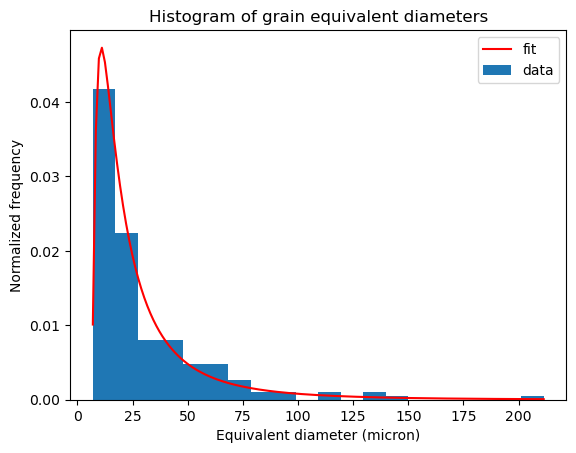

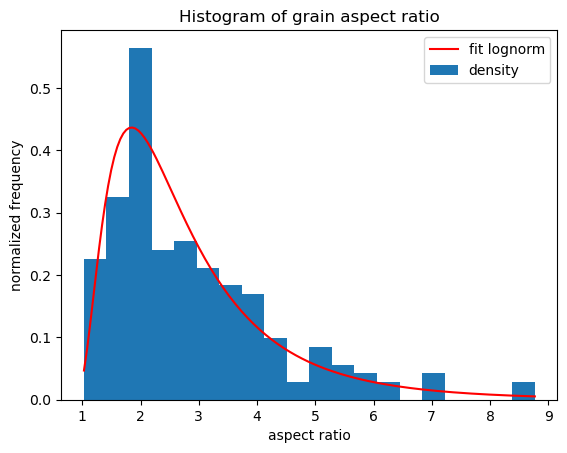

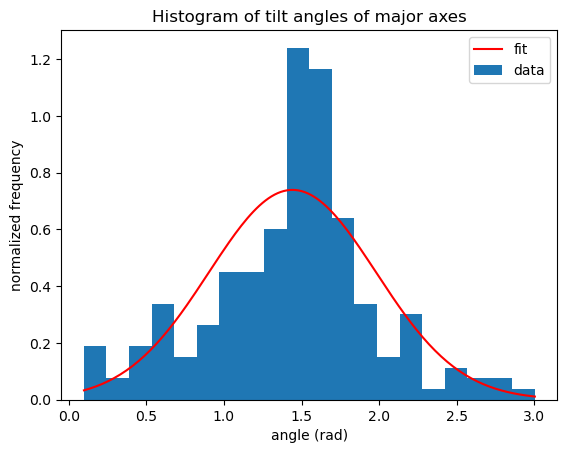

Analyzed microstructure with 183 grains.
Average grain size = 13.931 micron, average aspect ratio = 1.699,         average tilt angle = 82.598°


In [2]:
fname = 'ebsd_316L_500x500.ang'  # name of ang file to be imported
matname = 'Iron fcc'  # material name for MTEX
matnumber = 4         # material number of austenite in CP UMAT
if knpy.MTEX_AVAIL:
    # read EBSD map and evaluate statistics of microstructural features
    ebsd = knpy.EBSDmap(fname, matname)
    gs_param = ebsd.gs_param
    ar_param = ebsd.ar_param
    om_param = ebsd.om_param
else:
    # MTEX is not available fall back to predefined values
    print('***Warning: Anaysis of EBSD maps is only possible with an ' +
          'existing MTEX installation in Matlab.')
    print('\nWill continue with predefined settings for microstructure.')
    gs_param = np.array([1.06083584, 6.24824603, 13.9309554])
    ar_param = np.array([0.67525027, 0.76994992, 1.69901906])
    om_param = np.array([0.53941709, 1.44160447])


### 3. Pack ellipsoids and generate voxelized RVE

Generating particle distribution based on user defined statistics


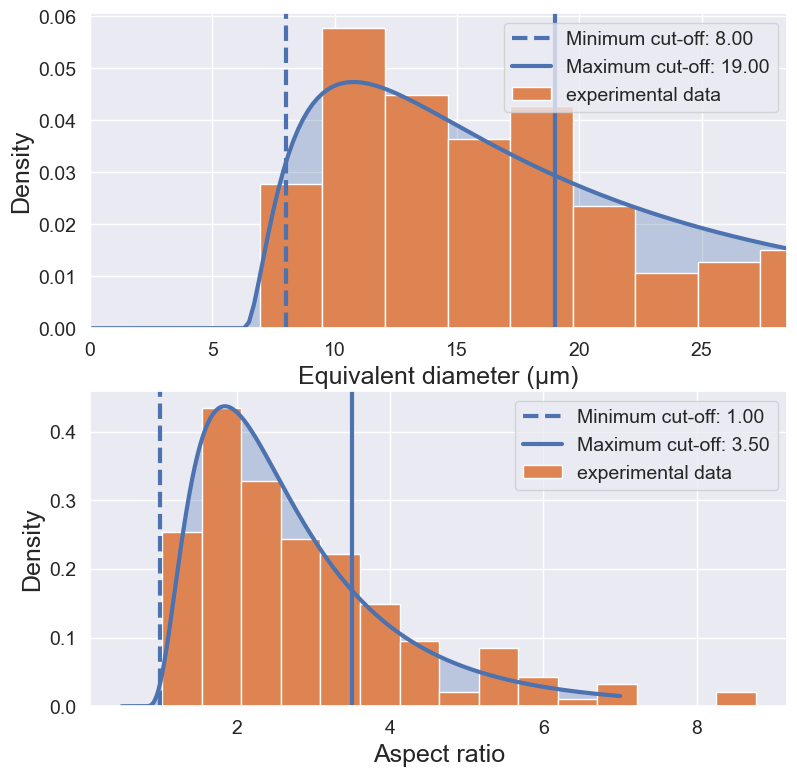

Creating an RVE based on user defined statistics
    Total number of grains        = 55
    RVE side lengths (X, Y, Z)    = 50, 50, 50
    Number of voxels (X, Y, Z)    = 30, 30, 30
    Voxel resolution (X, Y, Z)    = 1.6667, 1.6667, 1.6667
    Total number of voxels (C3D8) = 27000

Starting particle simulation
    Creating simulation box of required dimensions
    Creating particles from distribution statistics
    Particle packing by growth simulation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:17<00:00, 40.32it/s]


Completed particle packing
112 overlapping particles detected after packing
Kinetic energy of particles after packing: 14.120582743460664
Initial kinetic energy: 14.120582743460664



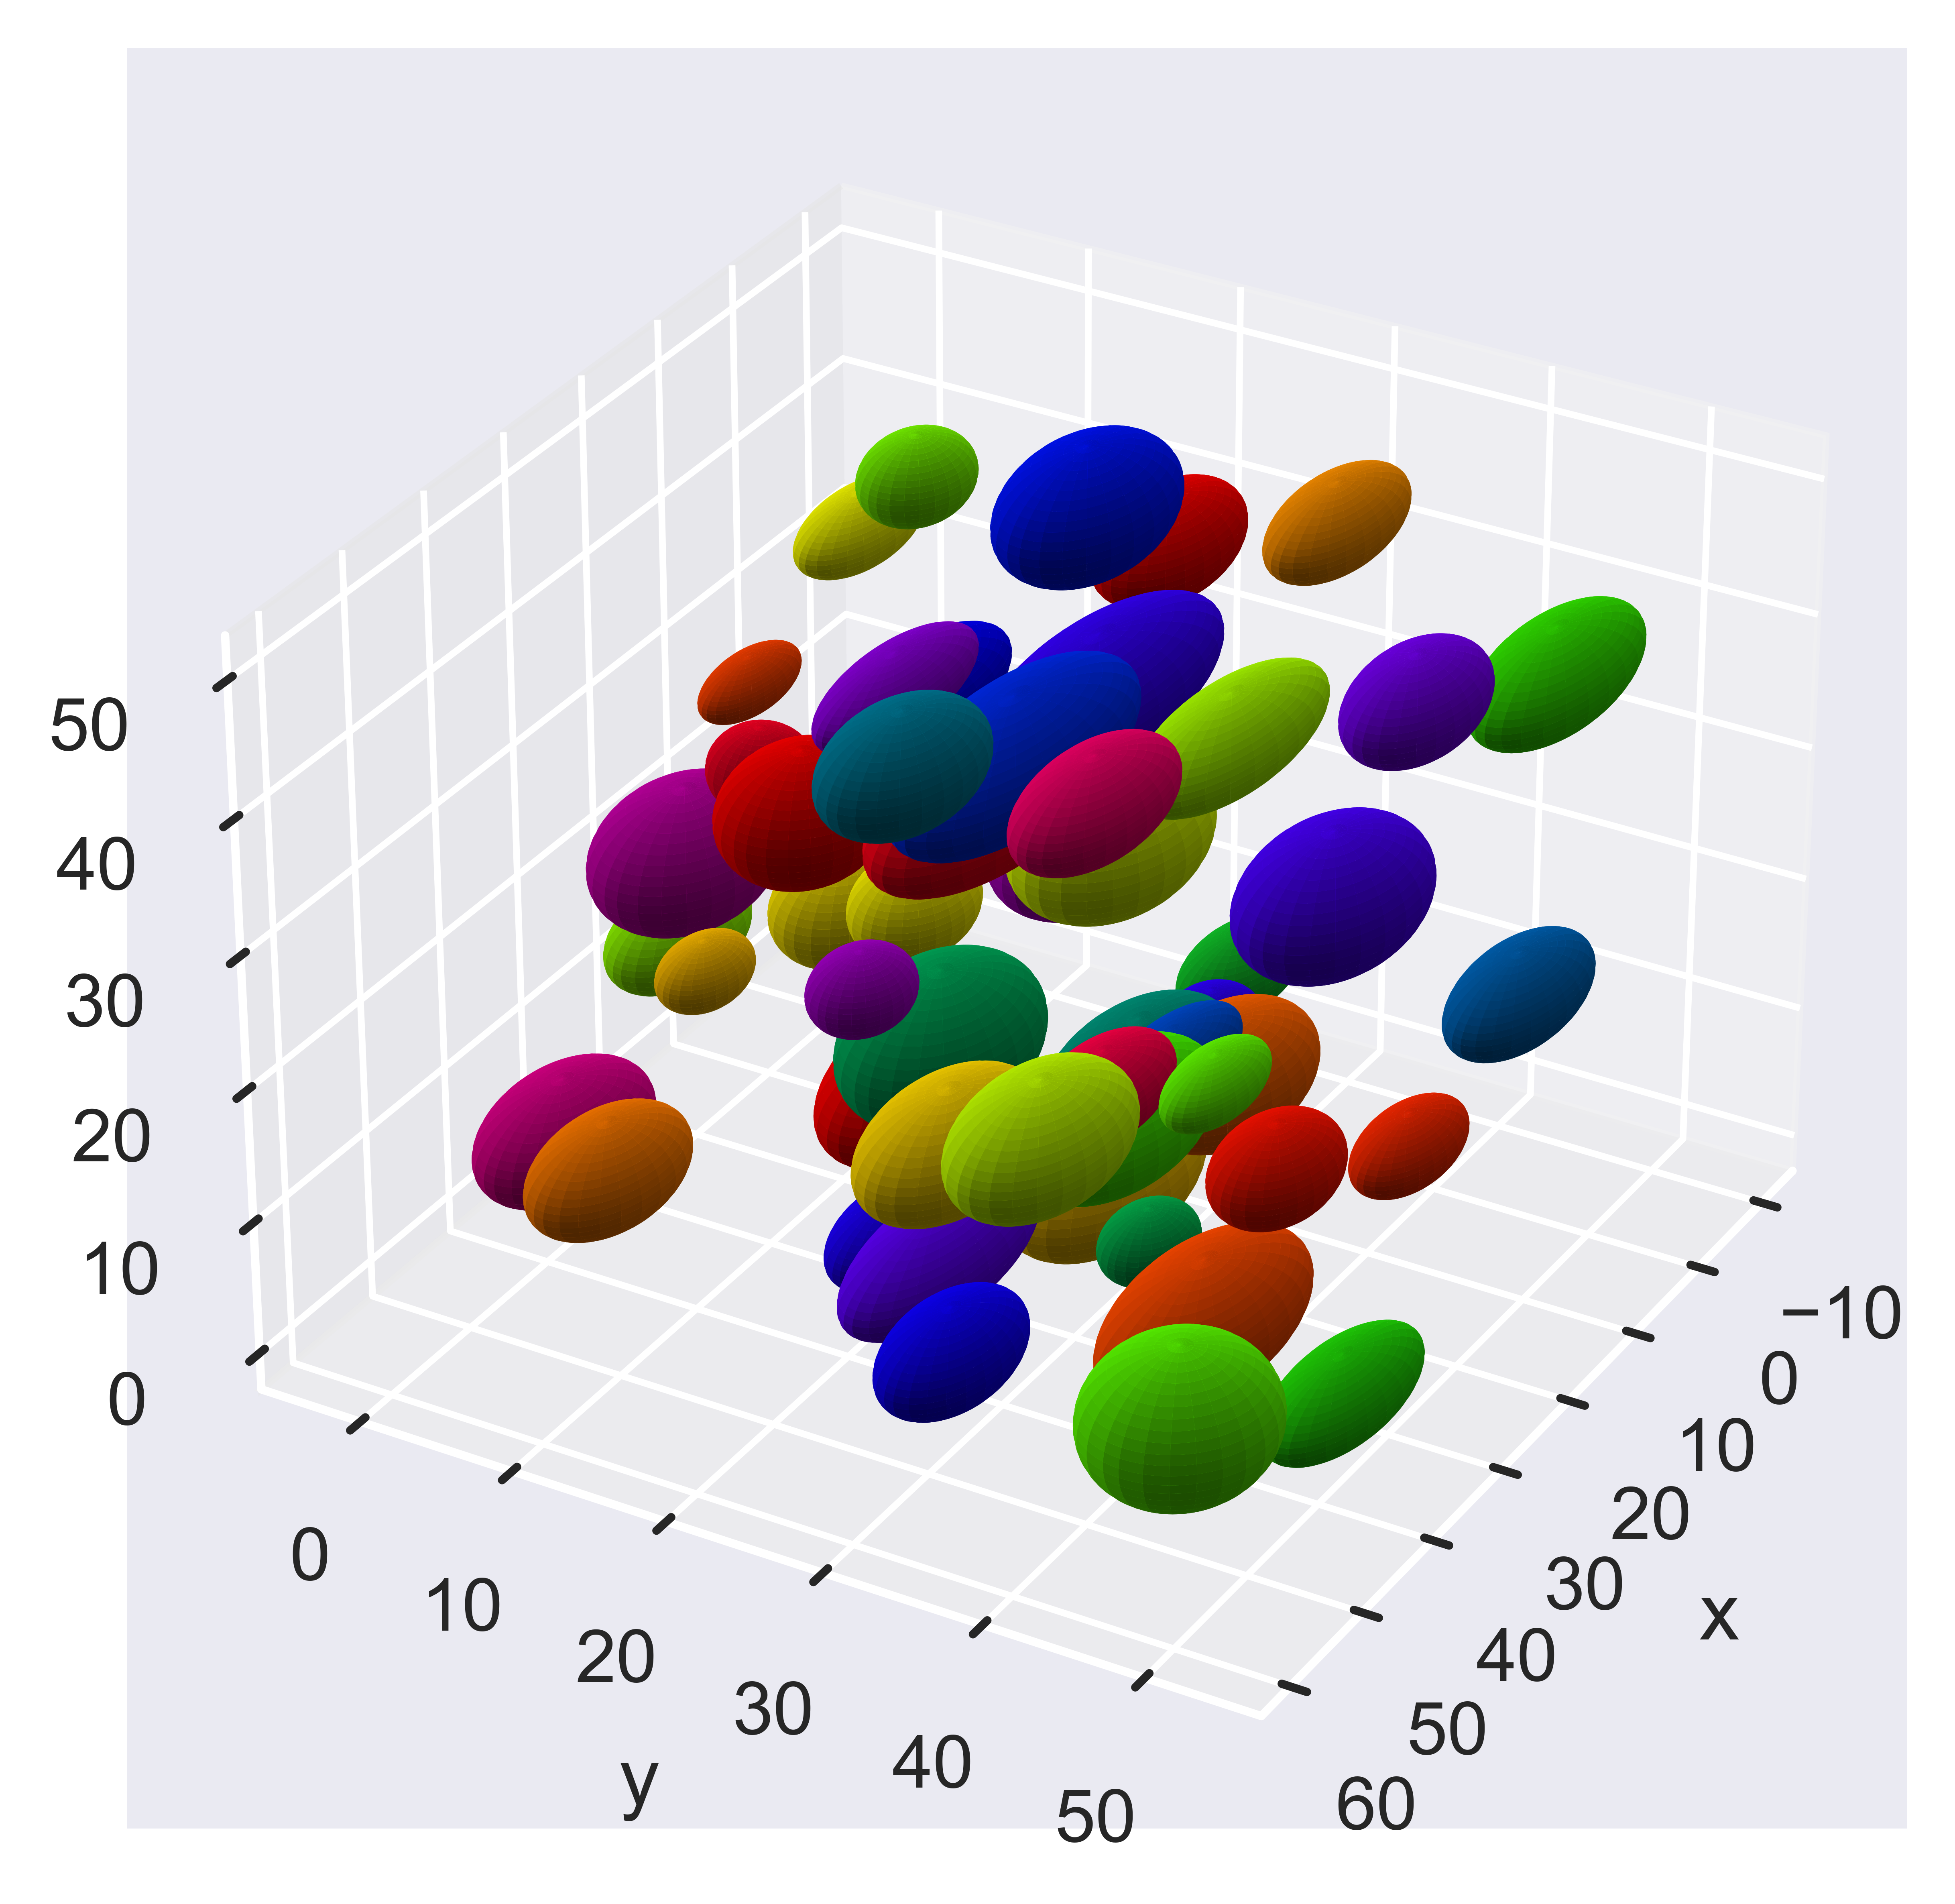

In [3]:
# create dictionary with statistical information obtained from EBSD map
# gs_param : [std deviation, mean grain size, offset of lognorm distrib.]
# ar_param : [std deviation, mean aspect ration, offset of gamma distrib.]
# om_param : [std deviation, mean tilt angle]
Nv = 30
size = 50
periodic = True
ms_stats = knpy.set_stats(gs_param, ar_param, om_param,
                          deq_min=8., deq_max=19., asp_min=1., asp_max=3.5,
                          omega_min=0., omega_max=2*np.pi, voxels=Nv, size=size,
                          periodicity=periodic, VF=1.0, phasename=matname, phasenum=0)

# Create box with ellipsoids that represent future grains
ms = knpy.Microstructure(descriptor=ms_stats, name=fname+'_RVE')
ms.init_stats(gs_data=ebsd.gs_data, ar_data=ebsd.ar_data)
ms.init_RVE()
ms.pack()
ms.plot_ellipsoids()



Starting RVE voxelization
    Generating voxels inside RVE
### create voxels 29791 (29791, 3)
    Assigning voxels to grains


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 22763056.88it/s]


        Grain 18_L is not voxelized, as particle 18_L overlap condition is inadmissible
        Grain 27_FL is not voxelized, as particle 27_FL overlap condition is inadmissible
Completed RVE voxelization



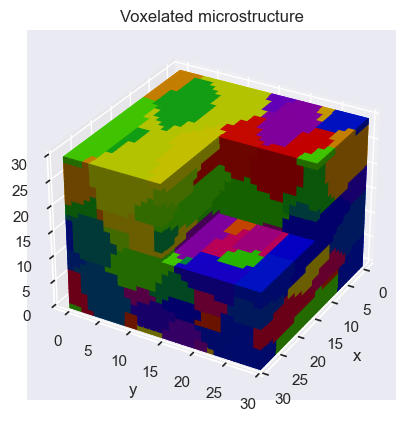

In [4]:
# Create voxel structure and assign each voxel to a grain according to ellipsoids
ms.voxelize()
ms.plot_voxels(sliced=True)


Generated Delaunay tesselation of grain vertices.
Assigning 1704 tetrahedra to grains ...


1704it [02:15, 12.58it/s]
/Users/alexander/opt/anaconda3/envs/knpy/lib/python3.10/site-packages/kanapy/grains.py:462: UserWarning: No tet assigned to grain 6.
  warnings.warn(f'No tet assigned to grain {igr}.')


Finished generating polyhedral hulls for grains.
Mean absolute error of polyhedral vs. voxel volume of grains: 0.22572190118594568

Computing the L1-error between input and output diameter distributions
    L1 error between particle and grain geometries: 0.72727


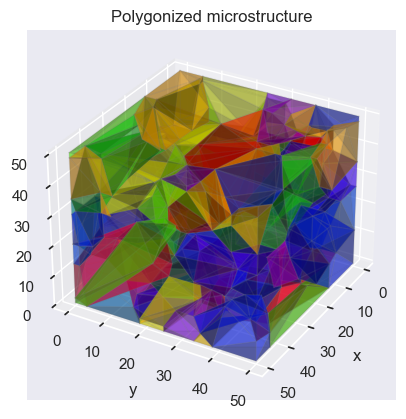


Plotting input & output statistics


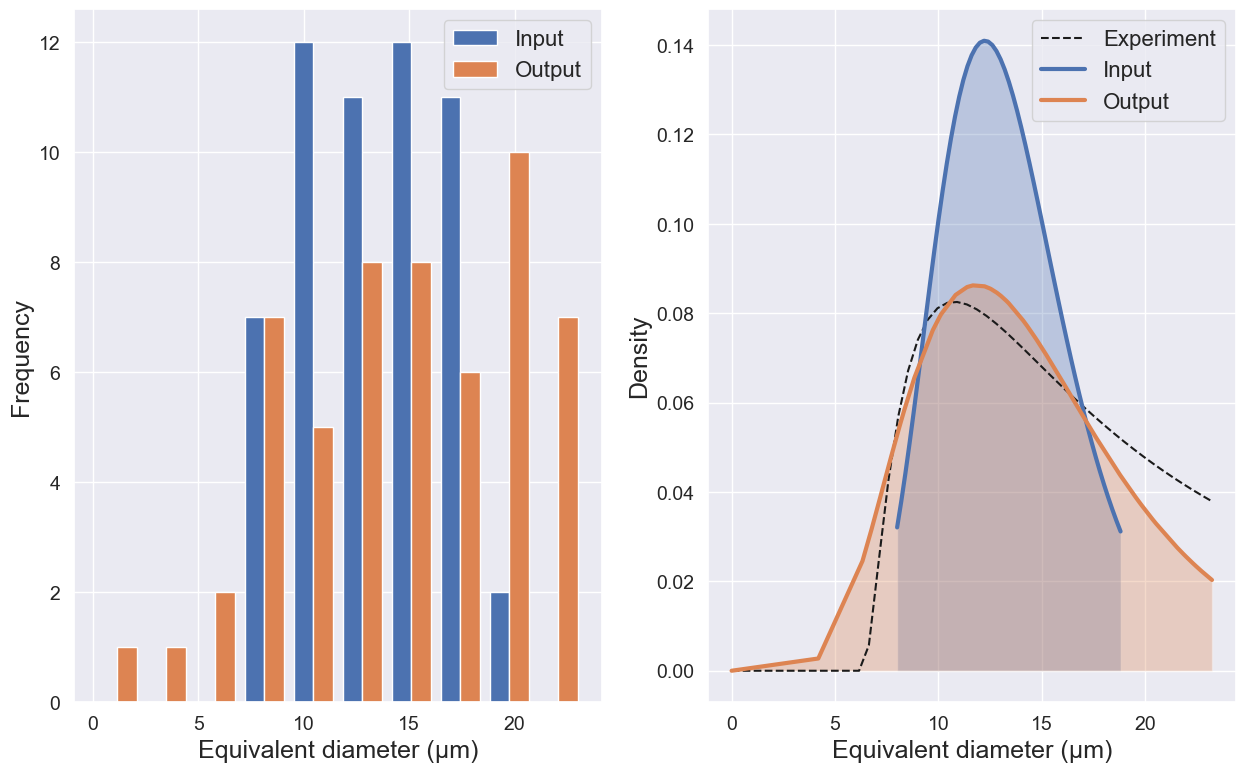

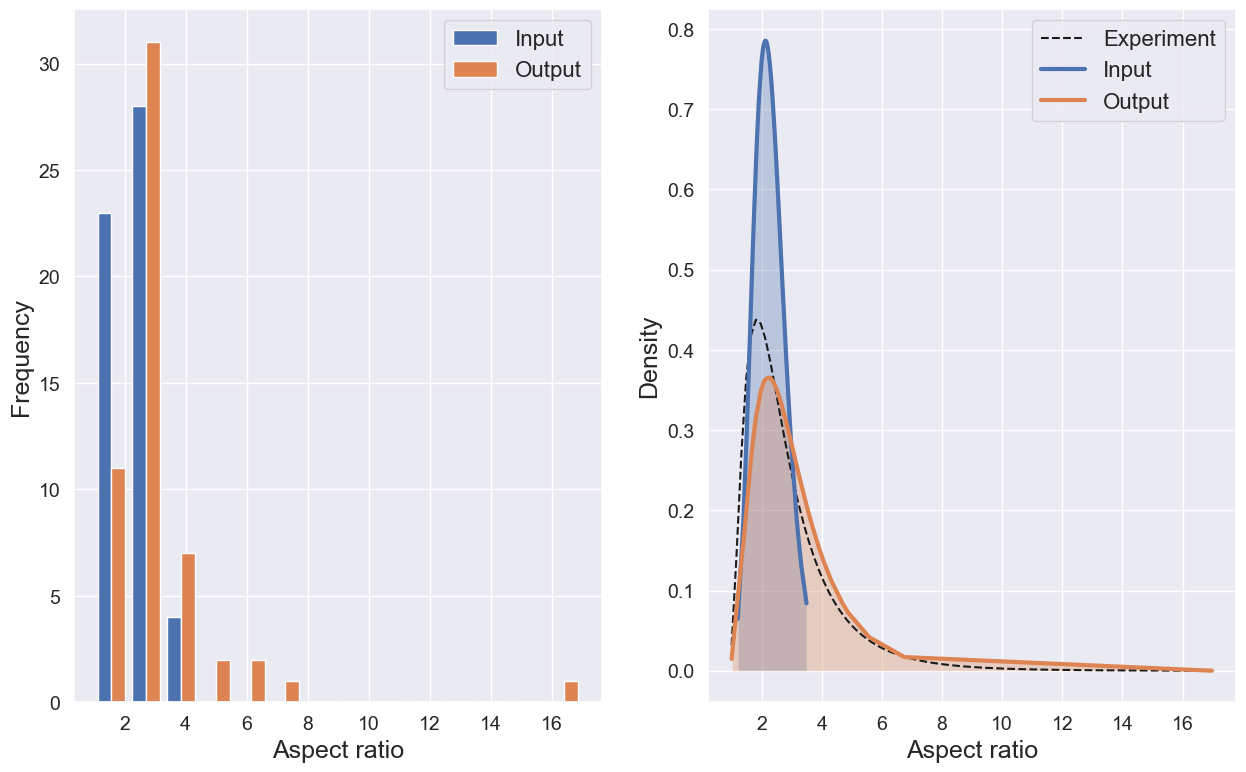

---->DONE!



In [6]:
# Create polygonized structure for voxelized grains and analyse statistics of synthetic microstructure
ms.generate_grains()
ms.plot_grains()
ms.res_data[0]['Unit_scale'] = 'um'
ms.plot_stats(gs_param=ebsd.gs_param, ar_param=ebsd.ar_param)

In [7]:
if not knpy.MTEX_AVAIL:
    raise ModuleNotFoundError('Generation of grainsorientation sets is only possible '+\
                              'with an existing MTEX installation in Matlab.')
    
# get list of orientations for grains in RVE matching the ODF of the EBSD map
ori_rve = ebsd.calcORI(ms.Ngr, ms.shared_area)

# write Abaqus input file for voxelated structure
ptag = 'pbc' if periodic else 'non-pbc'
ms.output_abq('v', name=f'from_ebsd_vox{Nv}_gr{ms.Ngr}_{ptag}.inp')
# write Euler angles of grains into Abaqus input file
knpy.writeAbaqusMat(matnumber, ori_rve)
!mv Material.inp 'from_ebsd_mat{matnumber}_gr{ms.Ngr}.inp'

Optimum kernel estimated from mean orientations of grains
 estimating optimal kernel halfwidth: 0%
 estimate optimal kernel halfwidth: 10%
 estimate optimal kernel halfwidth: 20%
 estimate optimal kernel halfwidth: 30%
 estimate optimal kernel halfwidth: 40%
 estimate optimal kernel halfwidth: 50%
 estimate optimal kernel halfwidth: 60%
 estimate optimal kernel halfwidth: 70%
 estimate optimal kernel halfwidth: 80%
 estimate optimal kernel halfwidth: 90%
 estimate optimal kernel halfwidth: 100%

time =

   28.0348


e =

    0.2528


e =

    0.2388


e =

    0.2321


e =

    0.2179


e =

    0.2154


e =

    0.1654


e =

    0.1629


e =

    0.1602


e =

    0.1551


e =

    0.1542


e =

    0.1532


e =

    0.1504


e =

    0.1180


e =

    0.1160


e =

    0.1145


e =

    0.1123


e =

    0.1114


e =

    0.1063


e =

    0.0971


e =

    0.0860


e =

    0.0720


e =

    0.0705


e =

    0.0645


e =

    0.0634


e =

    0.0597


e =

    0.0578


e =

    